# Calibration of Thymio

To calibrate the odometry in rotation (the only needed here) based on time and speed (the only possibility here, having no encoders) it is useful to have a program that allows to set a speed and count time. The following program allows to start and stop rotating, enabling to count how much time (in 10ms units) is taken to make 10 revolutions.

In [ ]:
import tdmclient.notebook
await tdmclient.notebook.start()

In [12]:
%%run_python

counting = 0
time = 0

timer_period[0] = 10 # milliseconds

@onevent 
def button_right(): # start counting
    global counting, time, motor_left_target, motor_right_target
    counting = 1
    time = 0
    motor_left_target = 100
    motor_right_target = -100

@onevent 
def button_center(): # stop counting
    global counting, motor_left_target, motor_right_target
    counting = 0
    motor_left_target = 0
    motor_right_target = 0

@onevent 
def timer0():
    global counting, time
    if counting == 1:
        time = time + 1

In [13]:
print(time)

0


**Time to make 10 revolutions : 1'30''850 = 90850 ms <br>
Time to make 1 revolution : 9085 ms**

In [72]:
thymio_speed_rads = 2 * np.pi/9.085
print(thymio_speed_rads)

0.6915999237401855


**Thymio rotation speed is 0.692 rad/s for a speed command of 100/-100**

In [73]:
thymio_speed_to_rads =  thymio_speed_rads / 100
print(thymio_speed_to_rads)

0.006915999237401855


**To go from Thymio speed to rad/s, the conversion factor is thymio_speed_to_rads = 0.00692**

Calibrate rotation : 

In [19]:
%%run_python

TURN = 2
ONETURN = 9085  # time in ms for oneturn
SAMPLING = 5

state = 0
time = 0

timer_period[0] = SAMPLING # 5 ms resolution

@onevent 
def button_forward():
    global state, TURN, time, motor_left_target, motor_right_target
    state = TURN
    time = 0
    motor_left_target = 100
    motor_right_target = -100

@onevent 
def button_center():
    global state, time, motor_left_target, motor_right_target
    state = 0
    time = 0
    motor_left_target = 0
    motor_right_target = 0

@onevent 
def timer0():
    global state, TURN, ONETURN, SAMPLING, time, motor_left_target, motor_right_target
    time = time + 1
    if state == TURN:
        if time > ONETURN*2//SAMPLING:
            time = 0
            state = 0
            motor_left_target = 0
            motor_right_target = 0

Calibrate translation + rotation :

In [21]:
%%run_python

FORWARD = 1
TURN = 2
ONETURN = 9085  # time in ms for oneturn
SAMPLING = 5

state = 0
time = 0

timer_period[0] = SAMPLING # 5 ms resolution

@onevent 
def button_forward():
    global state, FORWARD, time, motor_left_target, motor_right_target
    state = FORWARD
    time = 0
    motor_left_target = 102
    motor_right_target = 98

@onevent 
def button_center():
    global state, time, motor_left_target, motor_right_target
    state = 0
    time = 0
    motor_left_target = 0
    motor_right_target = 0

@onevent 
def timer0():
    global state, FORWARD, TURN, ONETURN, SAMPLING, time, motor_left_target, motor_right_target
    time = time + 1
    if state == FORWARD:
        if time > ONETURN*3//SAMPLING//2:
            time = 0
            state = TURN
            motor_left_target = 100
            motor_right_target = -100
            
    if state == TURN:
        if time > ONETURN*3//SAMPLING//2:  #thymio turned 360 + 180 degrees
            time = 0
            state = FORWARD
            motor_left_target = 102
            motor_right_target = 98

**To go forward with a command of 100 we need : <br>
motor_left_target = 102 <br>
motor_right_target = 98**

# Kalman Filter

### Mesure of the different constants and variances

    1) Mesure and store the data when Thymio goes forward and when it rotates : 

In [1]:
import tdmclient.notebook
from tdmclient import ClientAsync
client = ClientAsync()
node = await client.wait_for_node()
await node.lock()

Node 6ea4d2ee-c528-4a1a-bb20-88c043bafb8d

In [5]:
import matplotlib.pyplot as plt
from scipy.signal import find_peaks
import numpy as np
from tqdm import tqdm

In [2]:
from threading import Timer

class RepeatedTimer(object):
    def __init__(self, interval, function, *args):
        self._timer     = None
        self.interval   = interval
        self.function   = function
        self.args       = args
        self.is_running = False
        self.start()

    def _run(self):
        self.is_running = False
        self.start()
        self.function(*self.args)

    def start(self):
        if not self.is_running:
            self._timer = Timer(self.interval, self._run)
            self._timer.start()
            self.is_running = True

    def stop(self):
        self._timer.cancel()
        self.is_running = False

In [7]:
Ts = 0.1

def motors(left, right):
    return {
        "motor.left.target": [left],
        "motor.right.target": [right],
    }

def get_data(thymio_data):
    thymio_data.append({ "left_speed":node["motor.left.speed"],
                        "right_speed":node["motor.right.speed"]})
         
def get_data_speed(thymio_data):
    thymio_data.append({"ground":list(node["prox.ground.reflected"]), 
                        "left_speed":node["motor.left.speed"],
                        "right_speed":node["motor.right.speed"]})
    

Mesure the speed conversion constant : 

In [13]:
thymio_data_speed = []
await node.wait_for_variables() # wait for Thymio variables values
rt = RepeatedTimer(Ts, get_data_speed, thymio_data_speed) # it auto-starts, no need of rt.start()

try:
    # time.sleep would not work here, use asynchronous client.sleep method instead
    await client.sleep(5)
    node.send_set_variables(motors(102, 98))
    await client.sleep(11) # your long-running job goes here...
finally:
    rt.stop() # better in a try/finally block to make sure the program ends!
    node.send_set_variables(motors(0, 0))

[ 54  72  80  93 110 124 142]


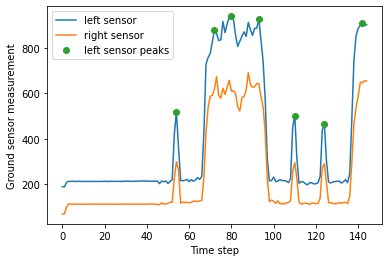

In [17]:
r_sensor = [x["ground"][0] for x in thymio_data_speed]
l_sensor = [x["ground"][1] for x in thymio_data_speed]
avg_ground = [(l+r)/2 for l, r in zip(l_sensor, r_sensor)]
l_peaks = find_peaks(l_sensor, height = 400, distance = 7)[0]

print(l_peaks)

plt.plot(l_sensor, label="left sensor")
plt.plot(r_sensor, label="right sensor")
plt.plot(l_peaks, [l_sensor[idx] for idx in l_peaks], "o", label = "left sensor peaks")
plt.xlabel("Time step")
plt.ylabel("Ground sensor measurement")
plt.legend()

In [23]:
thymio_mms_speed = 6*50/(Ts * (l_peaks[-1]-l_peaks[0]))
print("The Thymio's speed in mm/s is {}".format(thymio_mms_speed))

The Thymio's speed in mm/s is 34.090909090909086


**Thymio's speed is 34.1 mm/s for a command of 100**

In [24]:
thymio_speed_to_mms = thymio_mms_speed/100
print("To go from Thymio speed to mm/s, the conversion factor is {}".format(thymio_speed_to_mms))

To go from Thymio speed to mm/s, the conversion factor is 0.3409090909090909


**To go from Thymio speed to mm/s, the conversion factor is  thymio_speed_to_mms = 0.341**

In [63]:
distance_wheel = 95

**The distance between the two wheels is distance_wheel = 95 mm**

Mesure the translational and rotational speed variance when Thymio goes forward : 

In [77]:
thymio_data_forward = []
await node.wait_for_variables() # wait for Thymio variables values
rt = RepeatedTimer(Ts, get_data, thymio_data_forward) # it auto-starts, no need of rt.start()

try:
    # time.sleep would not work here, use asynchronous client.sleep method instead
    await client.sleep(5)
    node.send_set_variables(motors(102, 98))
    await client.sleep(25) # your long-running job goes here...
finally:
    rt.stop() # better in a try/finally block to make sure the program ends!
    node.send_set_variables(motors(0, 0))

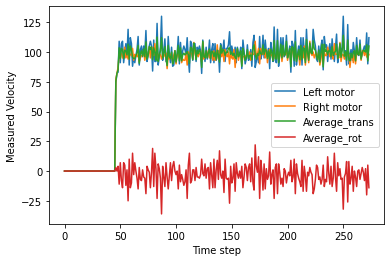

In [93]:
l_speed = [x["left_speed"] for x in thymio_data_forward]
r_speed = [x["right_speed"] for x in thymio_data_forward]
avg_speed_trans = [(x["left_speed"]+ x["right_speed"])/2 for x in thymio_data_forward]
avg_speed_rot = [(x["right_speed"] - x["left_speed"]) for x in thymio_data_forward]
plt.plot(l_speed, label="Left motor")
plt.plot(r_speed, label="Right motor")
plt.plot(avg_speed_trans, label="Average_trans")
plt.plot(avg_speed_rot, label="Average_rot")
plt.xlabel("Time step")
plt.ylabel("Measured Velocity")
plt.legend()

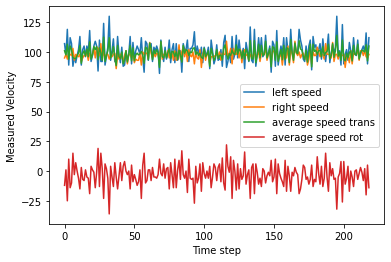

In [94]:
plt.plot(l_speed[55:], label="left speed")
plt.plot(r_speed[55:], label="right speed")
plt.plot(avg_speed_trans[55:], label="average speed trans")
plt.plot(avg_speed_rot[55:], label="average speed rot")
plt.xlabel("Time step")
plt.ylabel("Measured Velocity")
plt.legend()

In [95]:
var_speed_trans = np.var(avg_speed_trans[55:]) * thymio_speed_to_mms**2
var_speed_rot = np.var(avg_speed_rot[55:]) * (thymio_speed_to_mms / distance_wheel)**2

print("The translational speed variance in mm^2/s^2 is {}".format(var_speed_trans))
print("The rotational speed variance in rad^2/s^2 is {}".format(var_speed_rot))

The translational speed variance in mm^2/s^2 is 3.11511698619281
The rotational speed variance in rad^2/s^2 is 0.0011822269781716244


 **Assuming that half og the varance is caused by the measurements and half is caused by perturbations to the states, this gives us :**

In [96]:
q_forward_trans = var_speed_trans/2 # variance on speed state
r_forward_trans = var_speed_trans/2 # variance on speed measurement
q_forward_rot = var_speed_rot/2 # variance on speed state
r_forward_rot = var_speed_rot/2 # variance on speed measurement
print(q_forward_trans)
print(q_forward_rot)

1.557558493096405
0.0005911134890858122


$q_t^F = 1.56 $ mm²/s² <br>
$r_t^F = 1.56 $ mm²/s² <br>
$q_r^F = 0.000591 $ rad²/s² <br>
$r_r^F = 0.000591 $ rad²/s² 

Mesure the speed variance when Thymio rotates : 

In [34]:
thymio_data_turn = []
await node.wait_for_variables() # wait for Thymio variables values
rt = RepeatedTimer(Ts, get_data, thymio_data_turn) # it auto-starts, no need of rt.start()

try:
    # time.sleep would not work here, use asynchronous client.sleep method instead
    await client.sleep(5)
    node.send_set_variables(motors(100, -100))
    await client.sleep(25) # your long-running job goes here...
finally:
    rt.stop() # better in a try/finally block to make sure the program ends!
    node.send_set_variables(motors(0, 0))

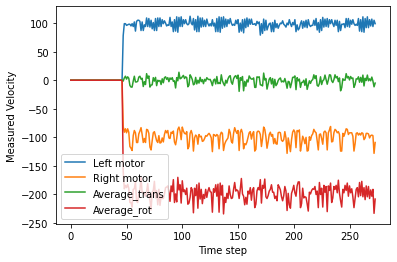

In [97]:
l_speed = [x["left_speed"] for x in thymio_data_turn]
r_speed = [x["right_speed"] for x in thymio_data_turn]
avg_speed_trans = [(x["left_speed"]+ x["right_speed"])/2 for x in thymio_data_turn]
avg_speed_rot = [(x["right_speed"] - x["left_speed"]) for x in thymio_data_turn]
plt.plot(l_speed, label="Left motor")
plt.plot(r_speed, label="Right motor")
plt.plot(avg_speed_trans, label="Average_trans")
plt.plot(avg_speed_rot, label="Average_rot")
plt.xlabel("Time step")
plt.ylabel("Measured Velocity")
plt.legend()

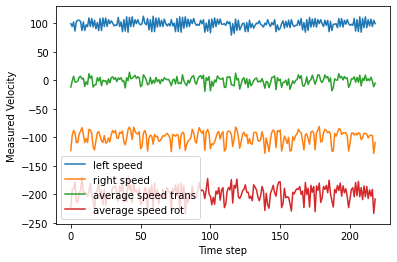

In [98]:
plt.plot(l_speed[55:], label="left speed")
plt.plot(r_speed[55:], label="right speed")
plt.plot(avg_speed_trans[55:], label="average speed trans")
plt.plot(avg_speed_rot[55:], label="average speed rot")
plt.xlabel("Time step")
plt.ylabel("Measured Velocity")
plt.legend()

In [99]:
var_speed_trans = np.var(avg_speed_trans[55:]) * thymio_speed_to_mms**2
var_speed_rot = np.var(avg_speed_rot[55:]) * (thymio_speed_to_mms / distance_wheel)**2

print("The translational speed variance in mm^2/s^2 is {}".format(var_speed_trans))
print("The rotational speed variance in rad^2/s^2 is {}".format(var_speed_rot))

The translational speed variance in mm^2/s^2 is 5.2362526151154825
The rotational speed variance in rad^2/s^2 is 0.0024439595587430903


 **Assuming that half og the varance is caused by the measurements and half is caused by perturbations to the states, this gives us :**

In [101]:
q_rotate_trans = var_speed_trans/2 # variance on speed state
r_rotate_trans = var_speed_trans/2 # variance on speed measurement
q_rotate_rot = var_speed_rot/2 # variance on speed state
r_rotate_rot = var_speed_rot/2 # variance on speed measurement
print(q_turn_trans)
print(q_turn_rot)

2.6181263075577412
0.0012219797793715452


$q_t^R = 2.62 $ mm²/s² <br>
$r_t^R = 2.62 $ mm²/s² <br>
$q_r^R = 0.00122 $ rad²/s² <br>
$r_r^R = 0.00122 $ rad²/s² 

**For the variance on the position:**
<br>
We chose these variances somehow arbitrarly : 
<br>
1. when thymio is going forward : 
<br>
$q_x^F = 0.02 $ mm² <br>
$q_y^F = 0.02 $ mm² <br>
$q_\theta^F = 0.000006 $ rad² 
2.when thymio is rotating : 
<br>
$q_x^R = 0.04 $ mm² <br>
$q_y^R = 0.04 $ mm² <br>
$q_\theta^R = 0.00001 $ rad²  

### The theory  

Let's start by defining the discrete-time state-space model $X_{k+1} = f(X_k)$ (where $X_k$ is a vector of the position and the translational and rotational velocities, i.e. $X_k = [P_k; V_k]$), assuming a fixed sampling time $T_s$, with the quantities of interest (position and speed)

Let the state $X_k$ contain the position $P_k = (x_k, y_k, \theta_k) $ with $x_k$, $y_k$ in mm and the orientation $\theta_k$ in rad, and the velocities $V_k = (\dot x_k, \dot y_k, \dot\theta_k)$ with the translational speeds $\dot x_k, \dot y_k$  in mm/s and the rotationnal speed $\dot\theta_k$ in rad/s. The linear discrete-time state-space model is : 

$X_{k+1}= A X_k + W_k $
   
where $W_k$ is the process noise with mean zero and covariance $Q$.
<br>
For simplicity we assume that all the process noises are independent. Hence $Q$ is diagonal.

where $ Q = \begin{bmatrix} q_x & 0 & 0 & 0 & 0 & 0\\ 0 & q_y & 0 & 0 & 0 & 0 \\ 0 & 0 & q_\theta & 0 & 0 & 0 \\ 
0 & 0 & 0 & q_\dot x & 0 & 0 \\ 0 & 0 & 0 & 0 & q_\dot y & 0 \\ 0 & 0 & 0 & 0 & 0 & q_\dot\theta \end{bmatrix} $



To implement the Kalman Filter one need to distinguish two different scenarios :

1. When Thymio is only going forward with a command of $100$ : the measurements at our disposal are the translational and rotational speed of the robot.
2. When Thymio is only rotating on itself with a command of $100$ / $-100$ : the measurements at our disposal are the translational and rotational speed of the robot

**Here we can only measure the velocities !**

We therefore consider two different velocities measurements $Y_k = HX_k + N_k$, one per scenario, where $N_k$ is the measurement noise with zero mean and covariance $R$

1. When Thymio is only going **forward** the measurement $Y^F$ is given by:

      $Y_k^F = H^FX_k + N_k^F =  \begin{bmatrix} 0 & 0 & 0 & 1 & 0 & 0 \\ 0 & 0 & 0 & 0 & 1 & 0 
      \\ 0 & 0 & 0 & 0 & 0 & 1\end{bmatrix}x_k+N_k^F$

      where $N_k^F$  is the measurement noise with zero mean and covariance $R^F$. 
      <br>
      For simplicity we assume that all the velocities measurement noise are independent.
      <br>
      Hence $R^F$ is a diagonal matrix $R^F = \begin{bmatrix} r_\dot x^F & 0 & 0\\ 0 & r_\dot y^F & 0 \\ 0 & 0 & r_\dot\theta^F \end{bmatrix}$
      <br>
      with :
      <br>
      $ r_\dot x^F = r_t^F * cos(\theta)^2 $
      <br>
      $ r_\dot y^F = r_t^F * sin(\theta)^2 $
      <br>
      $ r_\dot\theta^F = r_r^F $
      
      The linear discrete-time state-space model is : 

      $X_{k+1}= A^F X_k + W_k^F = \begin{bmatrix} 1 & 0 & 0 & T_s & 0 & 0\\ 0 & 1 & 0 & 0 & T_s & 0 \\ 0 & 0 & 1 & 0 & 0 & 0 \\ 
0 & 0 & 0 & 1 & 0 & 0 \\ 0 & 0 & 0 & 0 & 1 & 0 \\ 0 & 0 & 0 & 0 & 0 & 1 \end{bmatrix}X_k+W_k^F $
      
      For the process noises we have also : 
      $ Q^F = \begin{bmatrix} q_x^F & 0 & 0 & 0 & 0 & 0\\ 0 & q_y^F & 0 & 0 & 0 & 0 \\ 0 & 0 & q_\theta^F & 0 & 0 & 0 \\ 
      0 & 0 & 0 & q_\dot x^F & 0 & 0 \\ 0 & 0 & 0 & 0 & q_\dot y^F & 0 \\ 0 & 0 & 0 & 0 & 0 & q_\dot\theta^F \end{bmatrix} $
      <br>
      with :
      <br>
      $ q_\dot x^F = q_t^F * cos(\theta)^2 $
      <br>
      $ q_\dot y^F = q_t^F * sin(\theta)^2 $
      <br>
      $ q_\dot\theta^F = q_r^F $
      
2. When Thymio is only **rotating** the measurement $Y^R$ is given by:

      $Y_k^R = H^RX_k + N_k^R =  \begin{bmatrix} 0 & 0 & 0 & 1 & 0 & 0 \\ 0 & 0 & 0 & 0 & 1 & 0 
      \\ 0 & 0 & 0 & 0 & 0 & 1\end{bmatrix}x_k+N_k^R$

      where $N_k^R$  is the measurement noise with zero mean and covariance $R^R$. 
      <br>
      For simplicity we assume that all the velocities measurement noise are independent.
      <br>
      Hence $R^R$ is a diagonal matrix $R^R = \begin{bmatrix} r_\dot x^R & 0 & 0\\ 0 & r_\dot y^R & 0 \\ 0 & 0 & r_\dot\theta^R \end{bmatrix}$
      <br>
      with :
      <br>
      $ r_\dot x^R = r_t^R * cos(\theta)^2 $
      <br>
      $ r_\dot y^R = r_t^R * sin(\theta)^2 $
      <br>
      $ r_\dot\theta^R = r_r^R $
      
      The linear discrete-time state-space model is : 

      $X_{k+1}= A^R X_k + W_k^R = \begin{bmatrix} 1 & 0 & 0 & 0 & 0 & 0\\ 0 & 1 & 0 & 0 & 0 & 0 \\ 0 & 0 & 1 & 0 & 0 & T_s \\ 
0 & 0 & 0 & 1 & 0 & 0 \\ 0 & 0 & 0 & 0 & 1 & 0 \\ 0 & 0 & 0 & 0 & 0 & 1 \end{bmatrix}X_k+W_k^R $
      
      For the process noises we have also : 
      $ Q^R = \begin{bmatrix} q_x^R & 0 & 0 & 0 & 0 & 0\\ 0 & q_y^R & 0 & 0 & 0 & 0 \\ 0 & 0 & q_\theta^R & 0 & 0 & 0 \\ 
      0 & 0 & 0 & q_\dot x^R & 0 & 0 \\ 0 & 0 & 0 & 0 & q_\dot y^R & 0 \\ 0 & 0 & 0 & 0 & 0 & q_\dot\theta^R \end{bmatrix} $
      <br>
      with :
      <br>
      $ q_\dot x^R = q_t^R * cos(\theta)^2 $
      <br>
      $ q_\dot y^R = q_t^R * sin(\theta)^2 $
      <br>
      $ q_\dot\theta^R = q_r^R $